In [3]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import ugradio
mpl.rcParams['axes.linewidth'] = 1 #set the value globally
plt.rcParams['mathtext.fontset'],plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 16})


In [7]:
RA, DEC = 6.45, 62.726 #RA, DEC for our observations
JD = ugradio.timing.julian_date()-(1/24)
# JD = 2459632.3805556

correction = ugradio.doppler.get_projected_velocity(RA, DEC,JD).value / 1000
correction

-3.576072017773169

In [10]:
freqs=np.linspace(144,156,8192)
velocities=(((freqs+1270)-1420.4058)/(1420.4058))*(3e5)
velocities

array([-1352.95138896, -1352.64196557, -1352.33254219, ...,
        1180.91673974,  1181.22616313,  1181.53558652])

In [13]:
def T_0(data_file,noise_file,no_noise_file):
    on=fits.open(data_file)
    noise=fits.open(noise_file)
    no_noise=fits.open(no_noise_file)
    data=np.empty((8192,len(on)-1))
    noise_data=np.empty((8192,len(on)-1))
    no_noise_data=np.empty((8192,len(on)-1))
    for i in range(1,len(on)-1):
        data[:,i]=on[i].data['auto0_real']
        noise_data[:,i]=noise[i].data['auto0_real']
        no_noise_data[:,i]=no_noise[i].data['auto0_real']
    averaged_data=np.mean(data,axis=1)
    averaged_noise=np.mean(noise_data,axis=1)
    averaged_no_noise=np.mean(no_noise_data,axis=1)
    G=(90/(np.sum(averaged_noise-averaged_no_noise)))*np.sum(averaged_no_noise)
    maximum=(np.max((averaged_data/averaged_no_noise)[np.where(averaged_data/averaged_no_noise>0)]))
    T=G*np.abs((maximum-1))
    return T


def V_0(data_file,noise_file,no_noise_file):
    on=fits.open(data_file)
    noise=fits.open(noise_file)
    no_noise=fits.open(no_noise_file)
    data=np.empty((8192,len(on)-1))
    noise_data=np.empty((8192,len(on)-1))
    no_noise_data=np.empty((8192,len(on)-1))
    for i in range(1,len(on)-1):
        data[:,i]=on[i].data['auto0_real']
        noise_data[:,i]=noise[i].data['auto0_real']
        no_noise_data[:,i]=no_noise[i].data['auto0_real']
    averaged_data=np.mean(data,axis=1)
    averaged_noise=np.mean(noise_data,axis=1)
    averaged_no_noise=np.mean(no_noise_data,axis=1)# GET DATA
    ind_1=np.where(velocities>-50)[0][0]# Get indices for median
    ind_2=np.where(velocities<50)[0][-1]# Get indices for median
    G=(90/(np.sum(averaged_noise-averaged_no_noise)))*np.sum(averaged_no_noise)# Get Gain
    med=np.median((averaged_data[ind_1:ind_2]/averaged_no_noise[ind_1:ind_2]))# Get median
    y_data_fit = (averaged_data/averaged_no_noise)*G-G*med
    y_data_fit = y_data_fit[ind_1:ind_2]
    x_data_fit = velocities + correction
    x_data_fit = x_data_fit[ind_1:ind_2]
    plt.plot(x_data_fit,y_data_fit)
    fit_params_on1 = ugradio.gauss.gaussfit(x_data_fit, y_data_fit, amp=50, avg=20, sig=25)#get fit
    chisq_r_s = []
    for i in range(1):
        ys = (averaged_data/averaged_no_noise)*G-med*G
        xs = velocities + correction
        chisq_r_s.append(np.sum(np.abs(y_data_fit - ugradio.gauss.gaussval(x_data_fit, **fit_params_on1))**2) / (y_data_fit.size - 3) / np.std(y_data_fit[:190])**2)
    return (fit_params_on1['avg'][0])

<ipython-input-11-5ffca043d413>:16: RuntimeWarning: invalid value encountered in true_divide
  maximum=(np.max((averaged_data/averaged_no_noise)[np.where(averaged_data/averaged_no_noise>0)]))


T= 43.128820335803105
V= (14.86067712078736, 38.21479277016486)


<ipython-input-11-5ffca043d413>:37: RuntimeWarning: divide by zero encountered in true_divide
  y_data_fit = (averaged_data/averaged_no_noise)*G-G*med
<ipython-input-11-5ffca043d413>:37: RuntimeWarning: invalid value encountered in true_divide
  y_data_fit = (averaged_data/averaged_no_noise)*G-G*med
<ipython-input-11-5ffca043d413>:45: RuntimeWarning: divide by zero encountered in true_divide
  ys = (averaged_data/averaged_no_noise)*G-med*G
<ipython-input-11-5ffca043d413>:45: RuntimeWarning: invalid value encountered in true_divide
  ys = (averaged_data/averaged_no_noise)*G-med*G


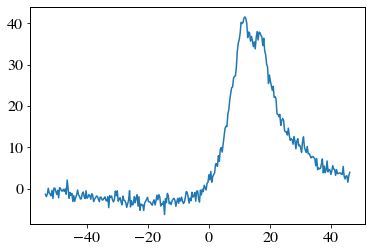

In [12]:
print('T=',T_0('celestial_10521.fits','celestial_10521_noise.fits','celestial_10521_noiseoff.fits'))
print('V=',V_0('celestial_10521.fits','celestial_10521_noise.fits','celestial_10521_noiseoff.fits'))
